In [1]:
include("../speciale_tools.jl")
import JLD
import PyPlot

In [18]:
figure_folder = "/Users/simon/Documents/DTU fag/Speciale/Figures_repport/results2/ribe"

"/Users/simon/Documents/DTU fag/Speciale/Figures_repport/results2/ribe"

In [3]:
zip_folder("/home/data/simon/processed/test_areas/ribe_new")

Process(`zip -q -j -r /home/data/simon/processed/test_areas/ribe_new.zip /home/data/simon/processed/test_areas/ribe_new`, ProcessExited(0))

In [4]:
zip_folder("/home/data/simon/processed/test_areas/vejle_new")

Process(`zip -q -j -r /home/data/simon/processed/test_areas/vejle_new.zip /home/data/simon/processed/test_areas/vejle_new`, ProcessExited(0))

In [5]:
zip_folder("/home/data/simon/processed/test_areas/houston_new")

Process(`zip -q -j -r /home/data/simon/processed/test_areas/houston_new.zip /home/data/simon/processed/test_areas/houston_new`, ProcessExited(0))

## Vejle



In [4]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/Final_data/ribe_new"
#data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
coh = [abs.(band) for band in _load_jld(coherence_VV_files[1:5],data_folder)]
coh = [coh[1][end:-1:1,:],(sum(coh[2:end])./length(coh[2:end]))[end:-1:1,:]];

VV = _load_jld(VV_files[1:6],data_folder)
VV_pre = dropdims(Statistics.median(cat(VV[2:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VV_co = copy(VV[1])[end:-1:1,:]
VV = 0;


VH = _load_jld(VH_files[1:6],data_folder)
VH_pre = dropdims(Statistics.median(cat(VH[2:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VH_co = copy(VH[1])[end:-1:1,:]
VH = 0;

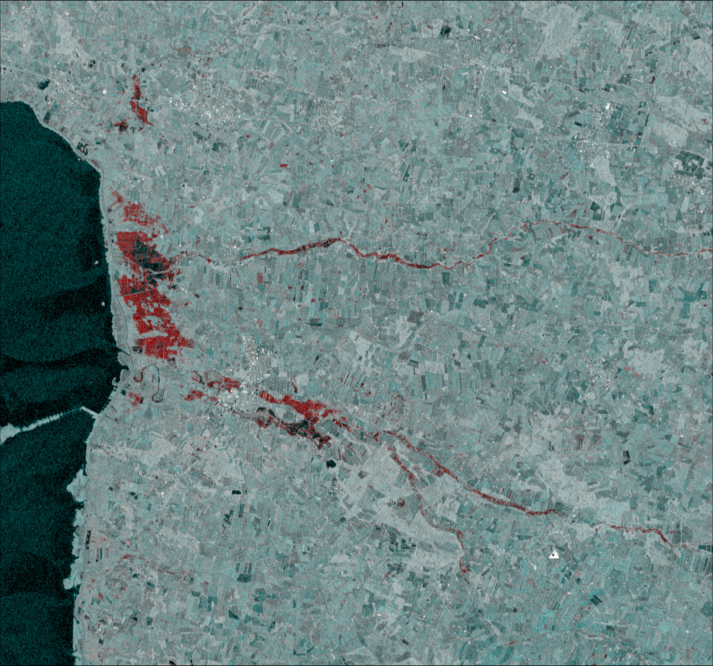

In [5]:
imgVV = pretty_img([VV_co,VV_pre],min_vv,max_vv)
imgVH = pretty_img([VH_co,VH_pre],min_vh,max_vh)

In [6]:
img_bw = pretty_img([VV_co,VV_co],min_vv,max_vv,1);
img_bw_vh = pretty_img([VH_co,VH_co],min_vh,max_vh,1);

## Bare_soil

### VV

In [7]:
flood_band = 10 .*log10.(VV_co);
ref_band = 10 .*log10.(VV_pre);
change_band = flood_band .- ref_band;

In [8]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;

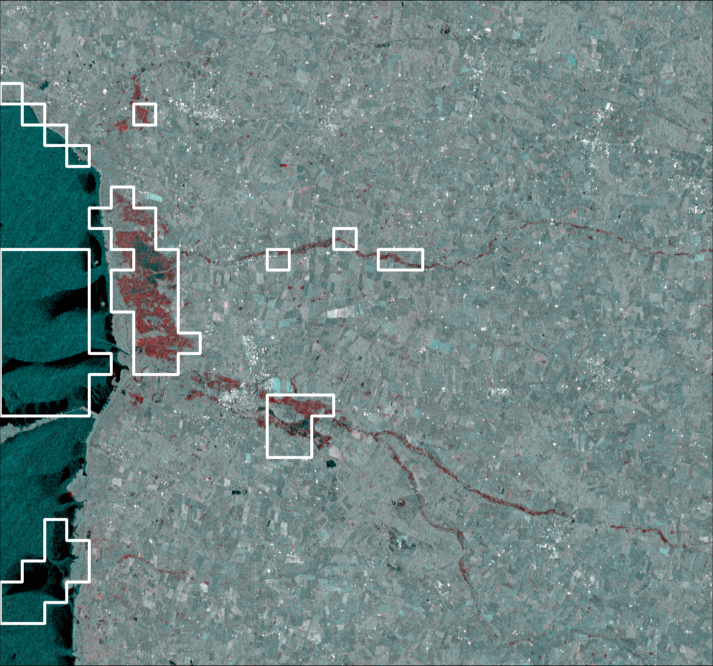

In [9]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,get_edges(bm_mask),(1,1,1)) # white

file_path = joinpath(figure_folder,"vv_tiles")
FileIO.save(file_path*".png",img_save)
img_save

In [10]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;
y_seed

-13.35

In [11]:
t_0 = [-13, -0.2]
res = Optim.optimize(
    t -> sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)
thresholds1 = res.minimizer
f1 = sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-12.980635070800782, -0.20186996459960938], 0.0010503450807119057)

In [12]:
rg_mask = (flood_band .<thresholds1[1]) .& (change_band.<thresholds1[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [13]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<thresholds1[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);

In [14]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

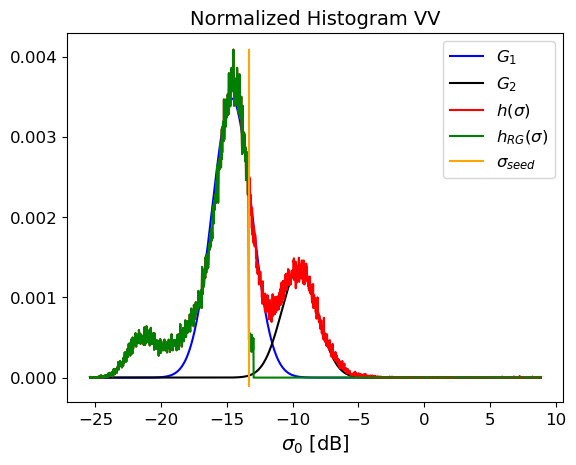

In [15]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

#file_path = joinpath(figure_folder,"VV_histogram_flood.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]",fontsize=14)
PyPlot.title("Normalized Histogram VV",fontsize=14)
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"],
    prop=Dict("size"=> 12))

PyPlot.xticks( fontsize=12)
PyPlot.yticks(fontsize=12)

#PyPlot.savefig(file_path)

rg_mask = (flood_band .<thresholds1[1]) .& (change_band.<thresholds1[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [16]:
hsba_vv = flood_mask .& .!(ref_mask);

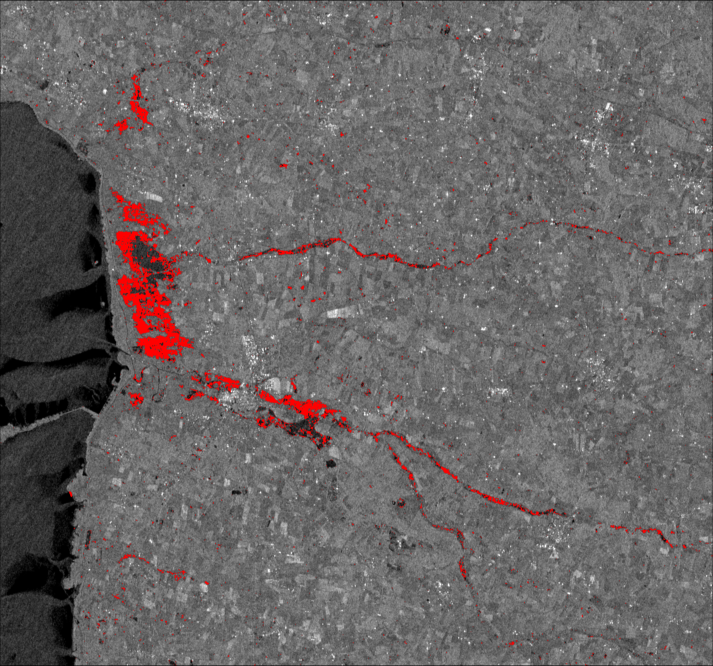

In [17]:
img_save = add_mask(img_bw,hsba_vv,(1,0,0)) # 

file_path = joinpath(figure_folder,"vv_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [18]:
file_name = joinpath(data_folder,"hsba_VV.jld")
JLD.save(file_name, "data",hsba_vv);

### VH

In [19]:
flood_band = 10 .*log10.(VH_co);
ref_band = 10 .*log10.(VH_pre);
change_band = flood_band .- ref_band;

In [20]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;

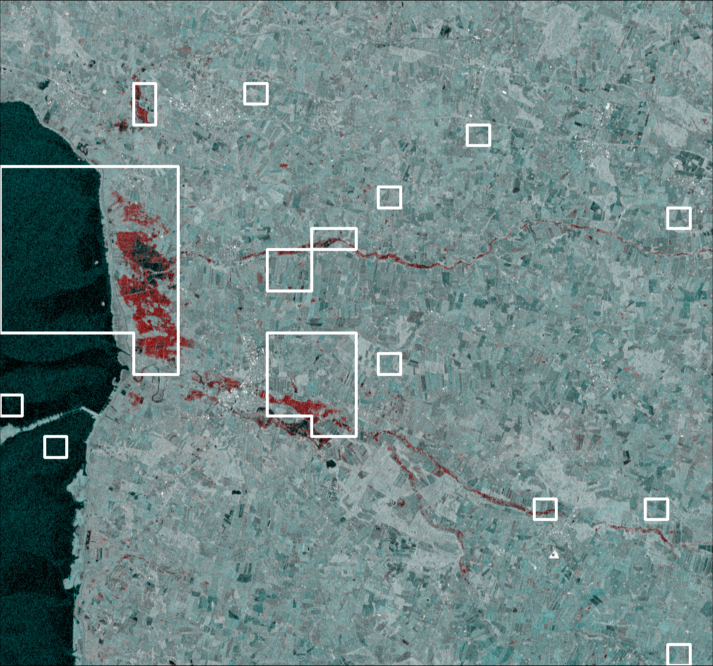

In [21]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,get_edges(bm_mask),(1,1,1)) # white

file_path = joinpath(figure_folder,"vh_tiles")
FileIO.save(file_path*".png",img_save)
img_save

In [22]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;
y_seed

-22.255000000000003

In [23]:
t_0 = [-21.5, -1.0]
res = Optim.optimize(
    t -> sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)
thresholds1 = res.minimizer
f1 = sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-26.8625, -1.0], 0.0004124952174522232)

In [26]:
rg_mask = (flood_band .<thresholds1[1]) .& (change_band.<thresholds1[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [24]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

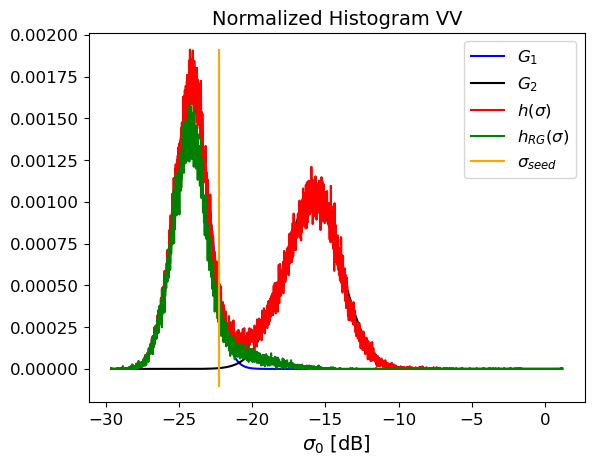

([-0.00025, 0.0, 0.00025, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.0022500000000000003], PyCall.PyObject[PyObject Text(0, -0.00025, '−0.00025'), PyObject Text(0, 0.0, '0.00000'), PyObject Text(0, 0.00025, '0.00025'), PyObject Text(0, 0.0005, '0.00050'), PyObject Text(0, 0.00075, '0.00075'), PyObject Text(0, 0.001, '0.00100'), PyObject Text(0, 0.00125, '0.00125'), PyObject Text(0, 0.0015, '0.00150'), PyObject Text(0, 0.00175, '0.00175'), PyObject Text(0, 0.002, '0.00200'), PyObject Text(0, 0.0022500000000000003, '0.00225')])

In [25]:
#file_path = joinpath(figure_folder,"VV_histogram_flood.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]",fontsize=14)
PyPlot.title("Normalized Histogram VV",fontsize=14)
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"],
    prop=Dict("size"=> 12))

PyPlot.xticks( fontsize=12)
PyPlot.yticks(fontsize=12)

#PyPlot.savefig(file_path)

In [27]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<thresholds1[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);

In [28]:
hsba_vh = flood_mask .& .!(ref_mask);

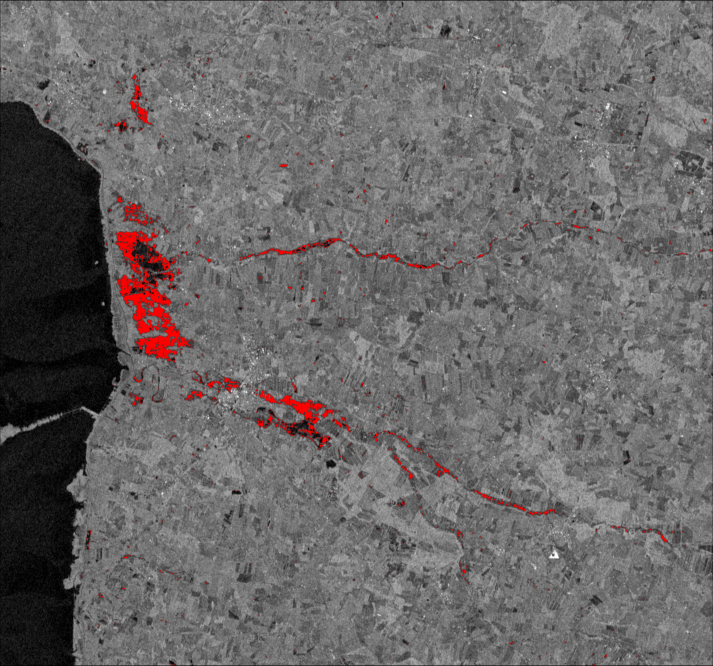

In [29]:
img_save = add_mask(img_bw_vh,hsba_vh,(1,0,0)) # 

file_path = joinpath(figure_folder,"vh_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [30]:
file_name = joinpath(data_folder,"hsba_VH.jld")
JLD.save(file_name, "data",hsba_vh);

## OWN method 

In [31]:
data_folder = "/home/data/simon/processed/test_areas/ribe_new"
#data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
coh = [abs.(band) for band in _load_jld(coherence_VV_files[1:5],data_folder)]
coh = [coh[1][end:-1:1,:],(sum(coh[2:end])./length(coh[2:end]))[end:-1:1,:]];

VV = _load_jld(VV_files[1:6],data_folder)
VV_pre = dropdims(Statistics.median(cat(VV[2:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VV_co = copy(VV[1])[end:-1:1,:]
VV = 0;


VH = _load_jld(VH_files[1:6],data_folder)
VH_pre = dropdims(Statistics.median(cat(VH[2:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VH_co = copy(VH[1])[end:-1:1,:]
VH = 0;

In [32]:
VV_co = 10 .*log10.(VV_co)
VV_pre = 10 .*log10.(VV_pre)
VH_co = 10 .*log10.(VH_co)
VH_pre = 10 .*log10.(VH_pre)

delta_VV = VV_co .- VV_pre
delta_VH = VH_co .- VH_pre
delta_coh = coh[1] .- coh[2];

In [33]:
sure_red = (delta_VV.<-2)  .& (delta_VH.<-2) .& (VV_co .< -3) .& (VH_co .< -7);

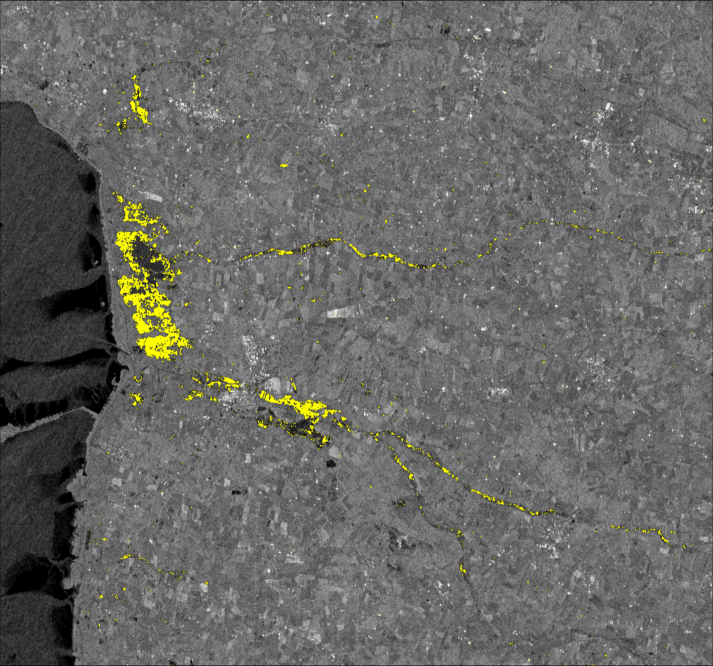

In [34]:
img_save = add_mask(img_bw,sure_red ,(1,1,0))

file_path = joinpath(figure_folder,"own_train")
FileIO.save(file_path*".png",img_save)
img_save

In [35]:
sure_red_VV = vec(VV_co[sure_red])
sure_red_VH = vec(VH_co[sure_red]);

In [36]:
mu_flood = [Statistics.mean(sure_red_VV),Statistics.mean(sure_red_VH)]

2-element Array{Float64,1}:
 -15.304262626160517
 -23.013767429552082

In [37]:
sigma_flood = Statistics.cov(cat(sure_red_VV,sure_red_VH, dims=2), dims=1)

2×2 Array{Float64,2}:
 2.25078  1.44104
 1.44104  3.36252

In [38]:
x,y = Misc.flatten(-22:0.01:-7,-30:0.01:-12);
mal = get_malhob(x,y,mu_flood,sigma_flood);
distri = Distributions.Chisq(2)
limit = Distributions.quantile.(distri, 0.90)
idx = (limit.<mal ).&( mal.<limit+0.1)
sum(idx)

7362

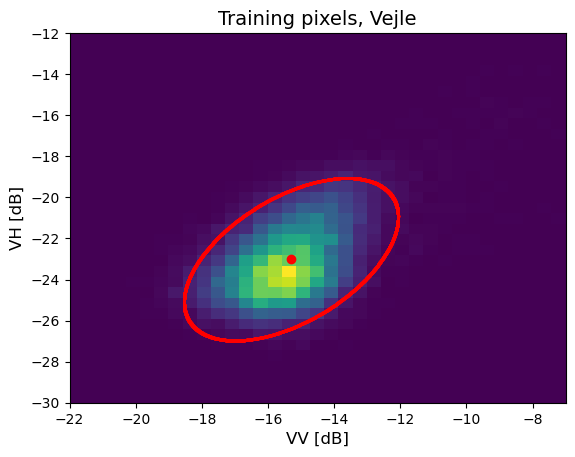

In [39]:
file_path = joinpath(figure_folder,"own_2dhist_train.png")
fig, axes = PyPlot.subplots()
axes.hist2d(sure_red_VV ,sure_red_VH,bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Training pixels, Vejle",fontsize=14)
PyPlot.savefig(file_path)

In [40]:
seed_mask = (delta_VV.<-2) .& (VV_co .< mu_flood[1]) .& (delta_VH.<-2) .& (VH_co .< mu_flood[2]);

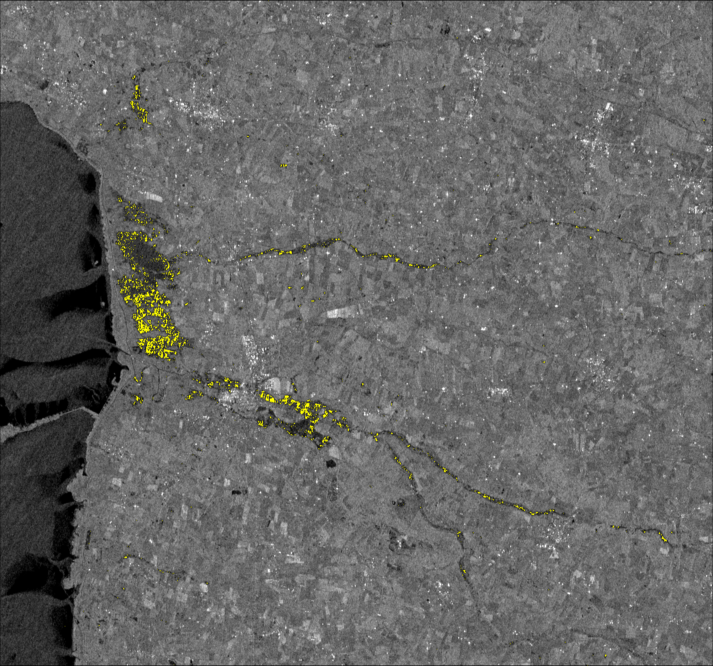

In [41]:
img_save = add_mask(img_bw,seed_mask ,(1,1,0))

file_path = joinpath(figure_folder,"own_seed_bare_soil")
FileIO.save(file_path*".png",img_save)
img_save

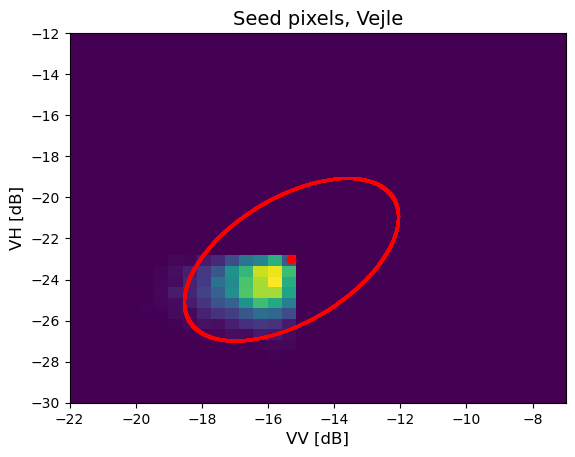

In [42]:
file_path = joinpath(figure_folder,"own_2dhist_seed.png")
fig, axes = PyPlot.subplots()
axes.hist2d(vec(VV_co[seed_mask]) ,vec(VH_co[seed_mask]),bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Seed pixels, Vejle",fontsize=14)
PyPlot.savefig(file_path)

In [43]:
rg_mask_change = ((delta_VV.<-2) .& (delta_VH.<0)) .| 
                ((delta_VV.<0) .& (delta_VH.<-2)) .| ( ( (delta_VV .+2).^2 .+ (delta_VH .+2).^2) .< 4 );

In [44]:
test_d = collect(1:0.1:12);
dist_cir = (VV_co.-mu_flood[1]).^2 .+ (VH_co .-mu_flood[2]).^2
loss_mal = [loss_rg_fit(VV_co,VH_co, seed_mask, rg_mask_change,mu_flood,sigma_flood,dist_cir, d.^2) for d in test_d ];

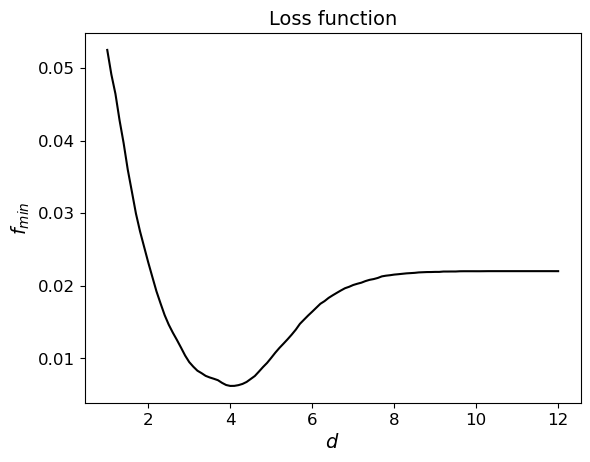

In [45]:
file_path = joinpath(figure_folder,"own_loss_d.png")
PyPlot.figure()
PyPlot.plot(test_d,loss_mal,color="k")
PyPlot.xlabel("\$ d \$", fontsize=14)
PyPlot.ylabel("\$ f_{min} \$", fontsize=14)
PyPlot.xticks( fontsize=12)
PyPlot.yticks(fontsize=12)
PyPlot.title("Loss function", fontsize=14)
PyPlot.savefig(file_path)

In [46]:
res = Optim.optimize(
    d -> loss_rg_fit(VV_co,VH_co, seed_mask, rg_mask_change,mu_flood,sigma_flood,dist_cir, d.^2),
    0, 10);
d_min = res.minimizer

4.044591145470811

In [47]:
rg_mask_int = ((VV_co .< mu_flood[1]) .& (VH_co .< mu_flood[2])) .| (dist_cir .< d_min.^2);

In [48]:
flood,steps = region_growing(seed_mask,rg_mask_int .& rg_mask_change);

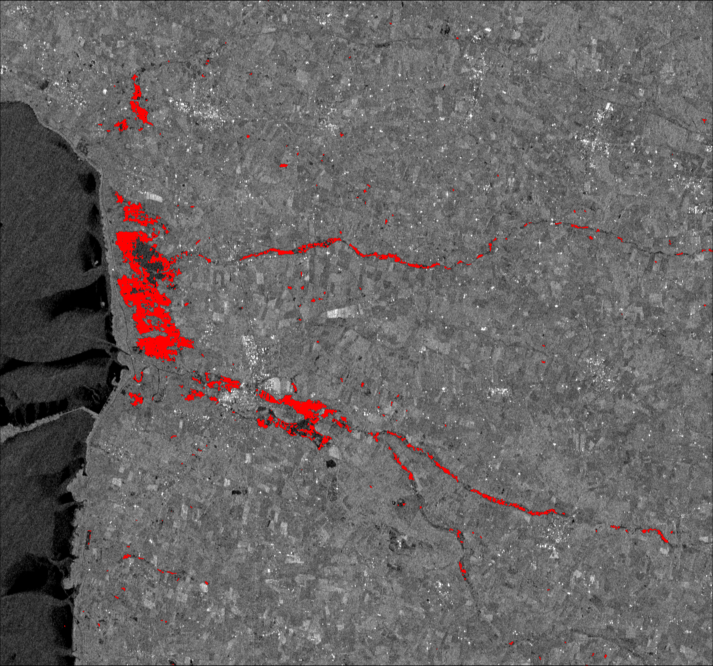

In [49]:
img_save = add_mask(img_bw,flood ,(1,0,0))

file_path = joinpath(figure_folder,"own_bare_soil")
FileIO.save(file_path*".png",img_save)
img_save

In [50]:

file_name = joinpath(data_folder,"own_bare_soil.jld")
JLD.save(file_name, "data",flood);

In [51]:
d_min

4.044591145470811

In [52]:

d_cir2 = ((x.-mu_flood[1]).^2 .+ (y.-mu_flood[2]).^2)
idx2 = (d_min^2 .<d_cir2 ).&(d_cir2 .<d_min^2 +0.2) .& (x .> mu_flood[1]) .& (y .> mu_flood[2])
sum(idx2)

1561

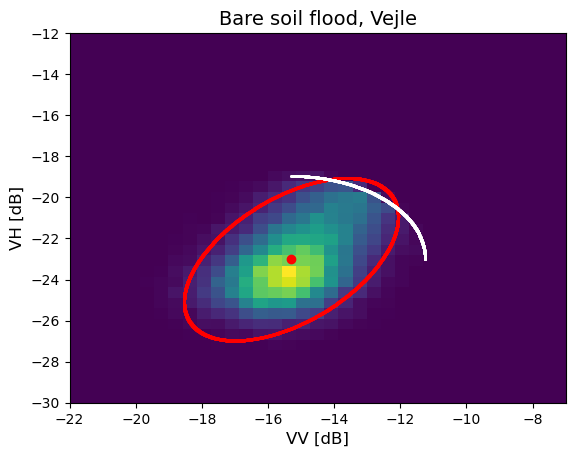

In [53]:
file_path = joinpath(figure_folder,"own_2dhist_bare_soil.png")
fig, axes = PyPlot.subplots()
axes.hist2d(vec(VV_co[flood]) ,vec(VH_co[flood]),bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
axes.scatter(x[idx2],y[idx2],color="w",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Bare soil flood, Vejle",fontsize=14)
PyPlot.savefig(file_path)

#### urban

In [54]:
sure_cyan = (delta_VV.>5) .& (coh[2].> 0.5)  .& (coh[1].< 0.25) .& (VV_pre.>-10) #.& (delta_VH.> 0) 
rg_mask = (delta_VV.>3) .& ((delta_coh .< -0.25));

In [55]:
urban_flood,steps = region_growing(sure_cyan,rg_mask );

In [56]:
sum(urban_flood)

566

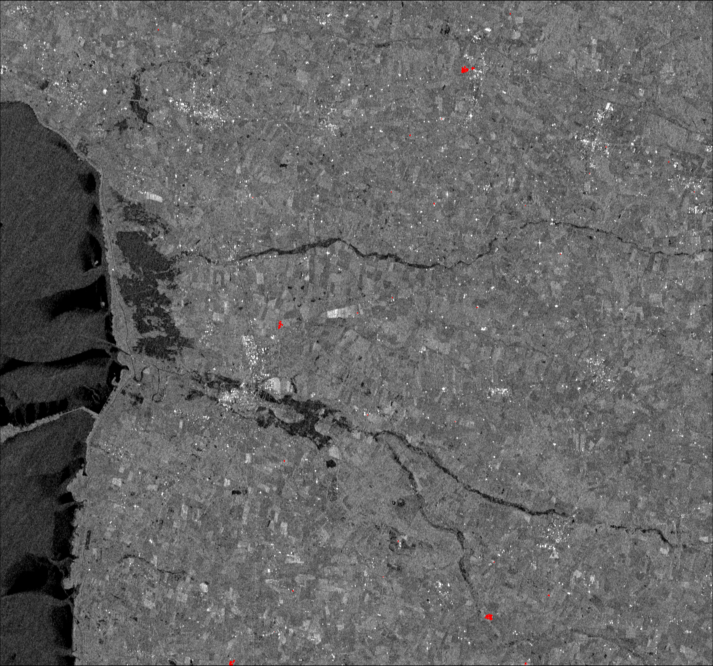

In [57]:
img_save = add_mask(img_bw,urban_flood ,(1,0,0))

file_path = joinpath(figure_folder,"own_urban")
FileIO.save(file_path*".png",img_save)
img_save

In [58]:

file_name = joinpath(data_folder,"own_urban.jld")
JLD.save(file_name, "data",urban_flood);

### Load

In [7]:
hsba_vv = JLD.load(joinpath(data_folder,"hsba_VV.jld"),"data");
hsba_vh = JLD.load(joinpath(data_folder,"hsba_VH.jld"),"data");
own_bare = JLD.load(joinpath(data_folder,"own_bare_soil.jld"),"data");
hasard = JLD.load(joinpath(data_folder,"hasard.jld"),"data")[end:-1:1,:].>0.5;

# Hasard

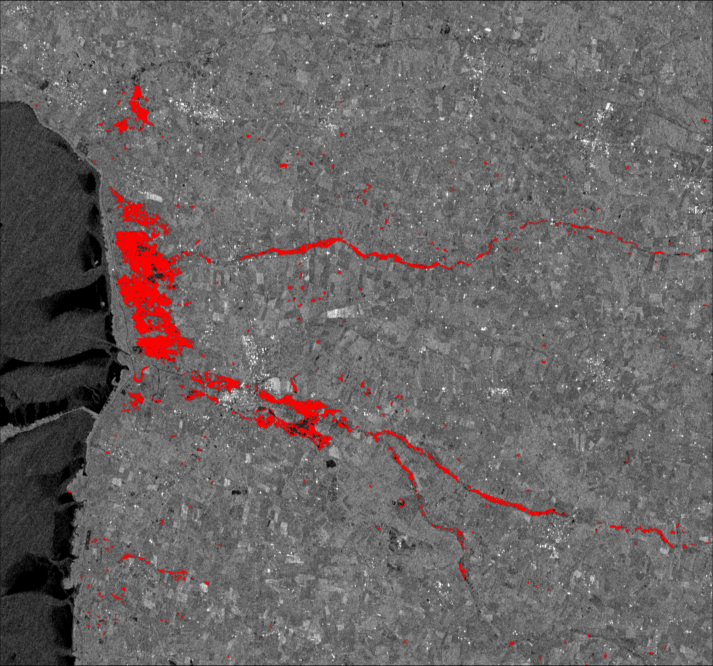

In [60]:
img_save = add_mask(img_bw,hasard ,(1,0,0))

file_path = joinpath(figure_folder,"hasard")
FileIO.save(file_path*".png",img_save)
img_save

In [61]:
flood_maps = [hsba_vv,hsba_vh,own_bare,hasard ];

In [62]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (1.0, 32232)               
 (0.7623136440837894, 16158)
 (0.7971901048668997, 23718)
 (0.6444601304644144, 26477)

In [63]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.5013030528667163, 16158)
 (1.0, 21196)               
 (0.6468808819575155, 19246)
 (0.4602034855418168, 18907)

In [64]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.7358525688756515, 23718)
 (0.9080015097188149, 19246)
 (1.0, 29752)               
 (0.6585288676857171, 27055)

In [65]:
i =4
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.8214507321916108, 26477)
 (0.8920079260237781, 18907)
 (0.9093506318902931, 27055)
 (1.0, 41084)               

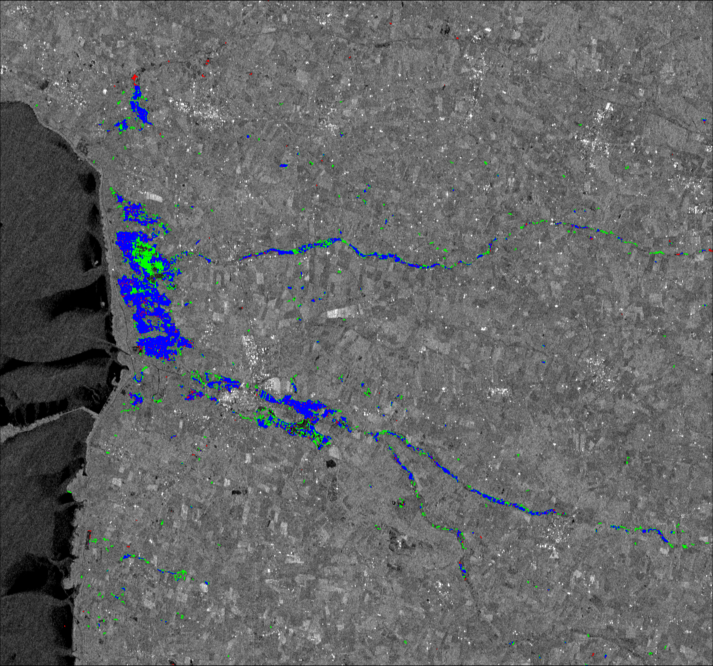

In [8]:
img_save = add_mask(img_bw,hasard,(0,1,0)) ### Green
img_save = add_mask(img_save,own_bare,(1,0,0)) ### red

img_save = add_mask(img_save,hasard .&own_bare ,(0,0,1))

#file_path = joinpath(figure_folder,"hasard_vs_own")
#FileIO.save(file_path*".png",img_save)
img_save

In [16]:
file_path

"/home/data/simon/result/figures_repport/results/ribe/compare_zoom1"

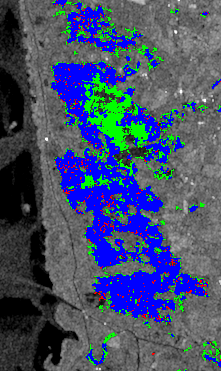

In [21]:

file_path = joinpath(figure_folder,"compare_zoom1")
FileIO.save(file_path*".png",img_save[400:770,180:400])
img_save[400:770,180:400]

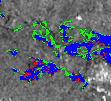

In [38]:
file_path = joinpath(figure_folder,"compare_zoom2")
FileIO.save(file_path*".png",img_save[720:820,350:460])
img_save[720:820,350:460]

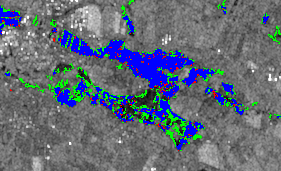

In [39]:
file_path = joinpath(figure_folder,"compare_zoom3")
FileIO.save(file_path*".png",img_save[750:920,460:740])
img_save[750:920,460:740]

In [67]:
zip_folder(figure_folder)

Process(`zip -q -j -r /home/data/simon/result/figures_repport/results/ribe.zip /home/data/simon/result/figures_repport/results/ribe`, ProcessExited(0))

In [ ]:
#### scalgo 